# Introduction to Neural Networks
Author: Marieme Ngom, adapting materials from Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset.

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="https://github.com/baharm1/ai-science-training-series/blob/main/02_intro_neural_networks/images/mnist_task.png?raw=1"  align="left"/>



In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 50.0MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.23MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.4MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.04MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

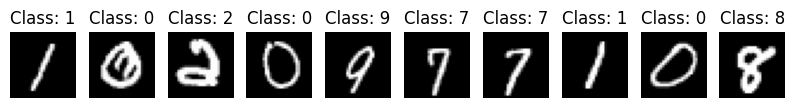

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression, like last week.
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication.

Note, like before, we consider multiple examples at once, adding another dimension to the input.


 <img src="https://github.com/baharm1/ai-science-training-series/blob/main/02_intro_neural_networks/images/LinearModel_1.png?raw=1"  align="center"/>



The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). Last week, we used mean squared error (MSE), but this week let's make two changes that make more sense for classification:
    - Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
    - Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd), like last week. For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate. As we learned last week, the learning rate controls how far we move during each step.

In [6]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # First, we need to convert the input image to a vector by using
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()

        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)

    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [7]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.






In [8]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [9]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [10]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [11]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.501379434188207, accuracy: 87.66874999999999
Epoch 0: val. loss: 0.49387358097319906, val. accuracy: 87.725
Epoch 1: training loss: 0.4213414849837621, accuracy: 89.05833333333332
Epoch 1: val. loss: 0.4122368718715424, val. accuracy: 88.96666666666667
Epoch 2: training loss: 0.387507284839948, accuracy: 89.66458333333334
Epoch 2: val. loss: 0.3778152549837498, val. accuracy: 89.59166666666667
Epoch 3: training loss: 0.3676126831769943, accuracy: 90.08749999999999
Epoch 3: val. loss: 0.3577276511078185, val. accuracy: 89.99166666666667
Epoch 4: training loss: 0.35407471406459806, accuracy: 90.43958333333333
Epoch 4: val. loss: 0.34418647593640267, val. accuracy: 90.28333333333333
CPU times: user 1min 16s, sys: 213 ms, total: 1min 16s
Wall time: 1min 19s


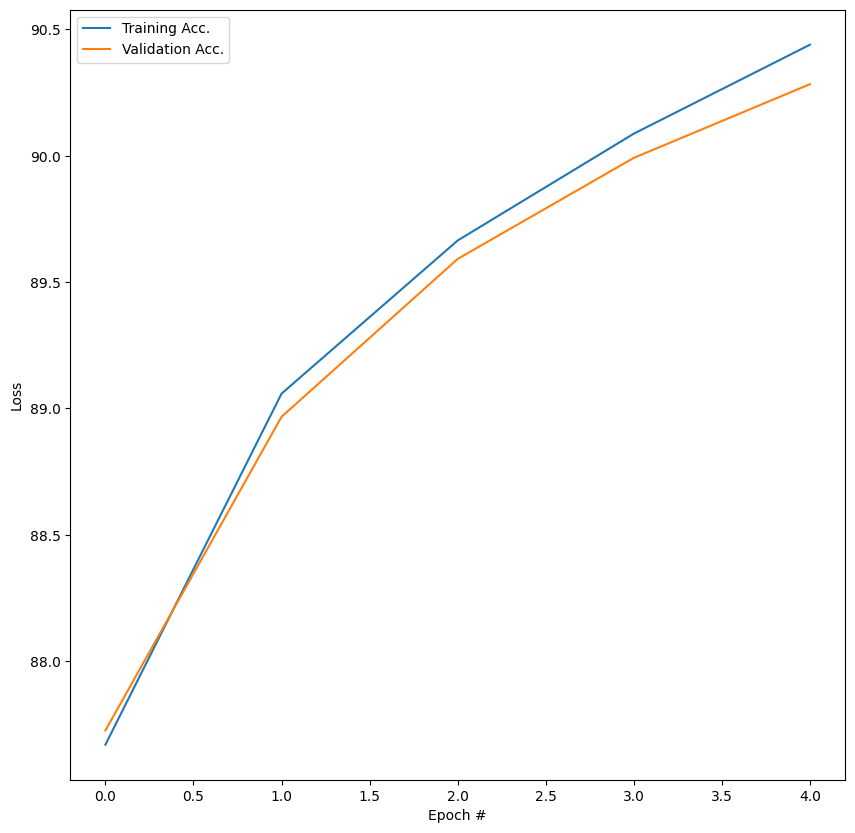

In [12]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

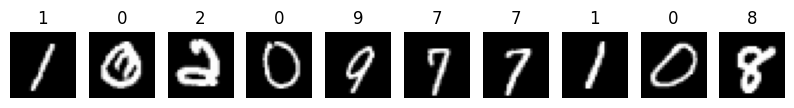

In [13]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc.

# Prediction

Let's see how our model generalizes to the unseen test data.



In [14]:
#For HW: cell to change batch size
#create dataloader for test data
# The dataloader makes our dataset iterable

batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [15]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.3325, test accuracy: 90.79%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [16]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the test data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


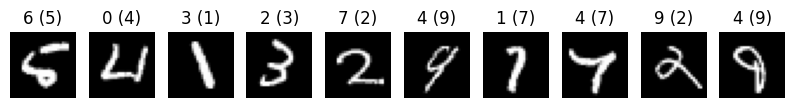

In [17]:
show_failures(linear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="https://github.com/baharm1/ai-science-training-series/blob/main/02_intro_neural_networks/images/shallow_nn.png?raw=1"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="https://github.com/baharm1/ai-science-training-series/blob/main/02_intro_neural_networks/images/activation.jpeg?raw=1"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="https://github.com/baharm1/ai-science-training-series/blob/main/02_intro_neural_networks/images/deep_nn_annotated.jpg?raw=1"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="https://github.com/baharm1/ai-science-training-series/blob/main/02_intro_neural_networks/images/bias_vs_variance.png?raw=1"  align="left"/>


Vizualization wrt to the accuracy and loss (Image source: [Baeldung](https://www.baeldung.com/cs/ml-underfitting-overfitting)):
<img src="https://github.com/baharm1/ai-science-training-series/blob/main/02_intro_neural_networks/images/acc_under_over.webp?raw=1"  align="center"/>


To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
Vanishing gradients: Gradients become small as they propagate backward through the layers. Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [18]:
#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [19]:
#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [20]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.7381247262954712, accuracy: 78.19583333333333
Epoch 0: val. loss: 0.7306493628532329, val. accuracy: 78.35
Epoch 1: training loss: 0.412994829416275, accuracy: 88.23125
Epoch 1: val. loss: 0.40391691441231586, val. accuracy: 88.25833333333334
Epoch 2: training loss: 0.30871471067269646, accuracy: 91.16458333333334
Epoch 2: val. loss: 0.3011022760195935, val. accuracy: 91.18333333333334
Epoch 3: training loss: 0.2504317739208539, accuracy: 92.85833333333333
Epoch 3: val. loss: 0.24514853391558566, val. accuracy: 92.84166666666667
Epoch 4: training loss: 0.21243062853813172, accuracy: 93.98125
Epoch 4: val. loss: 0.2114240103896628, val. accuracy: 93.66666666666667
CPU times: user 1min 17s, sys: 197 ms, total: 1min 17s
Wall time: 1min 19s


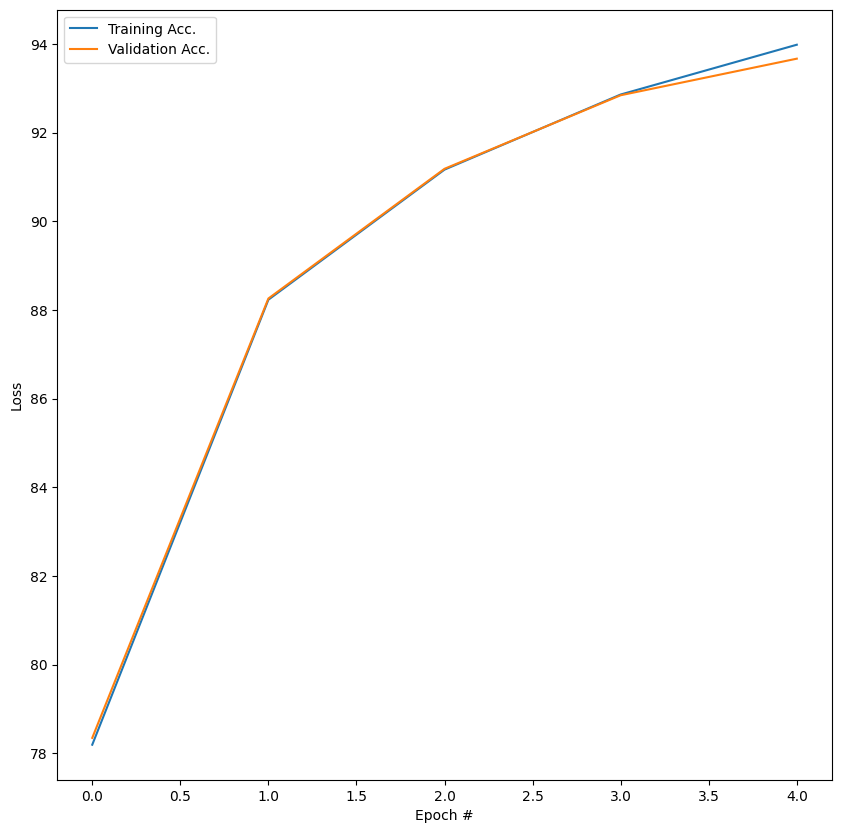

In [21]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


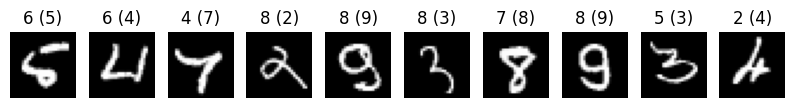

In [22]:
show_failures(nonlinear_model, test_dataloader)

# Recap
To train and validate a neural network model, you need:
- Data split into training/validation/test sets,
- A model with parameters to learn,
- An appropriate loss function,
- An optimizer (with tunable parameters such as learning rate, weight decay etc.) used to learn the parameters of the model.


# Homework

1. Compare the quality of your model when using different:
 - batch sizes,
 - learning rates,
 - activation functions.

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization.

# Homework Solution

In [31]:
# train and evaluate model
def train_epochs(epochs, train_dataloader, val_dataloader, nonlinear_model,
                 optimizer, scheduler=None):
  train_acc_all = []
  train_loss_all = []
  val_loss_all = []
  val_acc_all = []
  loss_fn = nn.CrossEntropyLoss()
  for j in range(epochs):
      train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

      if scheduler != None:
        #step the scheduler
        scheduler.step()

        # Print the current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {j+1}/{epochs}, Learning Rate: {current_lr}")

      # checking on the training loss and accuracy once per epoch
      acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
      train_acc_all.append(acc)
      train_loss_all.append(loss)
      print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

      # checking on the validation loss and accuracy once per epoch
      val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
      val_acc_all.append(val_acc)
      val_loss_all.append(val_loss)
      print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

  return{'model': nonlinear_model, 'loss': train_loss_all, 'acc': train_acc_all,
         'val_loss': val_loss_all, 'val_acc': val_acc_all}

# plot loss and accuracy of model on training and validation data
def plot_learning_curve(loss_acc):
  train_acc_all = loss_acc['acc']
  train_loss_all = loss_acc['loss']
  val_acc_all = loss_acc['val_acc']
  val_loss_all = loss_acc['val_loss']
  # number of epochs
  epochs = len(train_loss_all)

  fig, axs = plt.subplots(1, 2, figsize=(10, 4))
  axs[0].plot(range(epochs), train_acc_all, label = 'Training')
  axs[0].plot(range(epochs), val_acc_all, label = 'Validation')

  axs[1].plot(range(epochs), train_loss_all, label = 'Training')
  axs[1].plot(range(epochs), val_loss_all, label = 'Validation')

  axs[0].set_xlabel('Epoch #')
  axs[1].set_xlabel('Epoch #')

  axs[0].set_ylabel('Accuracy')
  axs[1].set_ylabel('Loss')
  plt.legend()
  plt.show()


## Experiment on batch sizes
Batch size = 64 has the highest accuracy among 32, 64, 128, and 256, although for all these batch sizes the final performance is about the same. By increasing the batch size, learning curve becomes smoother and converges to a plateau in fewer epochs. When the batch size is too small the training data is not representative of data and the loss difference between training and validation is higher.

Epoch 0: training loss: 0.22268292529881, accuracy: 93.38125000000001
Epoch 0: val. loss: 0.22575597974658013, val. accuracy: 93.22500000000001
Epoch 1: training loss: 0.15129340608262767, accuracy: 95.48333333333333
Epoch 1: val. loss: 0.1603940160870552, val. accuracy: 95.375
Epoch 2: training loss: 0.11670320843098064, accuracy: 96.50625000000001
Epoch 2: val. loss: 0.13685420914801458, val. accuracy: 95.99166666666666
Epoch 3: training loss: 0.10150009403773584, accuracy: 96.95833333333333
Epoch 3: val. loss: 0.1263912889622152, val. accuracy: 96.25833333333334
Epoch 4: training loss: 0.0856193009641332, accuracy: 97.37291666666667
Epoch 4: val. loss: 0.1100804239489759, val. accuracy: 96.68333333333334
Epoch 5: training loss: 0.08921736105166686, accuracy: 97.17916666666667
Epoch 5: val. loss: 0.11969195176536838, val. accuracy: 96.44166666666666
Epoch 6: training loss: 0.07336291550534467, accuracy: 97.70208333333333
Epoch 6: val. loss: 0.10852227712515741, val. accuracy: 96.7916

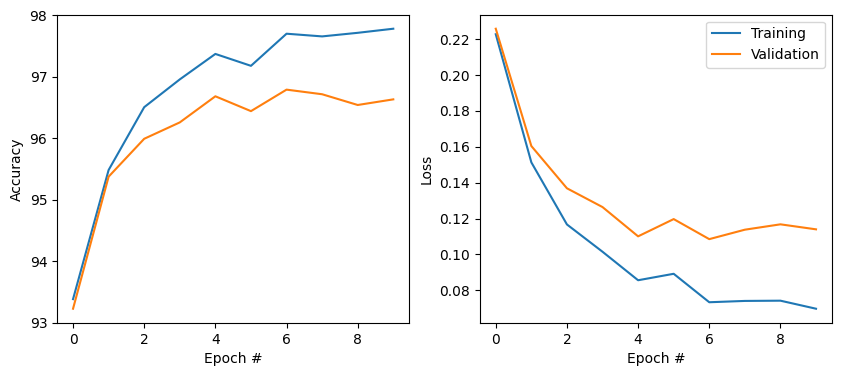

Test loss: 0.1119, test accuracy: 96.75%
Epoch 0: training loss: 0.27367088237404824, accuracy: 91.91458333333333
Epoch 0: val. loss: 0.2689667107497758, val. accuracy: 91.825
Epoch 1: training loss: 0.17903049467752377, accuracy: 94.70416666666667
Epoch 1: val. loss: 0.1796508484837064, val. accuracy: 94.525
Epoch 2: training loss: 0.1459000121007363, accuracy: 95.63958333333333
Epoch 2: val. loss: 0.15561483520519068, val. accuracy: 95.24166666666667
Epoch 3: training loss: 0.12532288455838958, accuracy: 96.25416666666666
Epoch 3: val. loss: 0.14090735570309645, val. accuracy: 95.73333333333333
Epoch 4: training loss: 0.10062792949688931, accuracy: 96.99166666666666
Epoch 4: val. loss: 0.11767856147080819, val. accuracy: 96.25
Epoch 5: training loss: 0.1015264954653879, accuracy: 96.85625
Epoch 5: val. loss: 0.12900336284408384, val. accuracy: 96.15833333333333
Epoch 6: training loss: 0.08578209867266318, accuracy: 97.40833333333333
Epoch 6: val. loss: 0.11113489708526338, val. accur

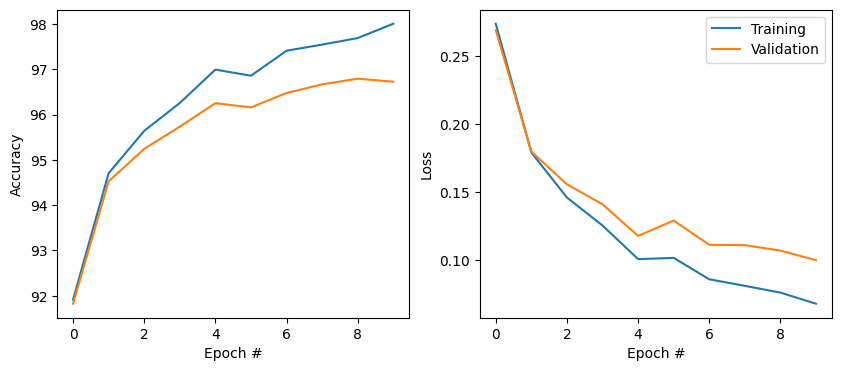

Test loss: 0.1003, test accuracy: 97.00%
Epoch 0: training loss: 0.39419469559192655, accuracy: 88.78125
Epoch 0: val. loss: 0.3866237240268829, val. accuracy: 89.075
Epoch 1: training loss: 0.25719996174176535, accuracy: 92.60000000000001
Epoch 1: val. loss: 0.2517238139630632, val. accuracy: 92.30000000000001
Epoch 2: training loss: 0.19454237606128058, accuracy: 94.36458333333333
Epoch 2: val. loss: 0.19515473395586014, val. accuracy: 94.25833333333333
Epoch 3: training loss: 0.15240255656838417, accuracy: 95.59375
Epoch 3: val. loss: 0.15858124549243044, val. accuracy: 95.35833333333333
Epoch 4: training loss: 0.134129839827617, accuracy: 96.13125
Epoch 4: val. loss: 0.1451199368989848, val. accuracy: 95.54166666666667
Epoch 5: training loss: 0.12512018000086148, accuracy: 96.31875
Epoch 5: val. loss: 0.14114228390315744, val. accuracy: 95.79166666666666
Epoch 6: training loss: 0.11057938926418623, accuracy: 96.75833333333334
Epoch 6: val. loss: 0.12802444303289373, val. accuracy: 

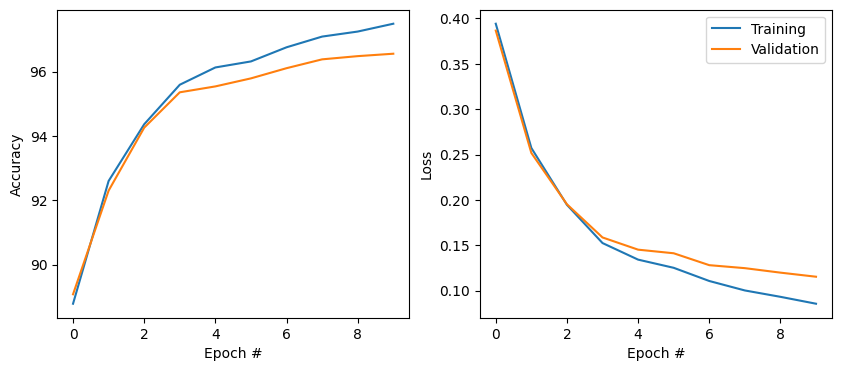

Test loss: 0.1161, test accuracy: 96.50%
Epoch 0: training loss: 1.0365550771672676, accuracy: 68.12083333333334
Epoch 0: val. loss: 1.0226082928637241, val. accuracy: 68.18333333333332
Epoch 1: training loss: 0.4197347806172168, accuracy: 87.85416666666667
Epoch 1: val. loss: 0.4118269827771694, val. accuracy: 88.00833333333333
Epoch 2: training loss: 0.3214358296641644, accuracy: 90.49583333333334
Epoch 2: val. loss: 0.31788337484319157, val. accuracy: 90.47500000000001
Epoch 3: training loss: 0.24512904747686487, accuracy: 92.975
Epoch 3: val. loss: 0.24361066266577294, val. accuracy: 92.76666666666667
Epoch 4: training loss: 0.21424878729467697, accuracy: 93.82083333333333
Epoch 4: val. loss: 0.21676656191653393, val. accuracy: 93.68333333333332
Epoch 5: training loss: 0.17565465060637353, accuracy: 94.87708333333333
Epoch 5: val. loss: 0.18076703427953922, val. accuracy: 94.69999999999999
Epoch 6: training loss: 0.15927956023431838, accuracy: 95.31041666666667
Epoch 6: val. loss: 

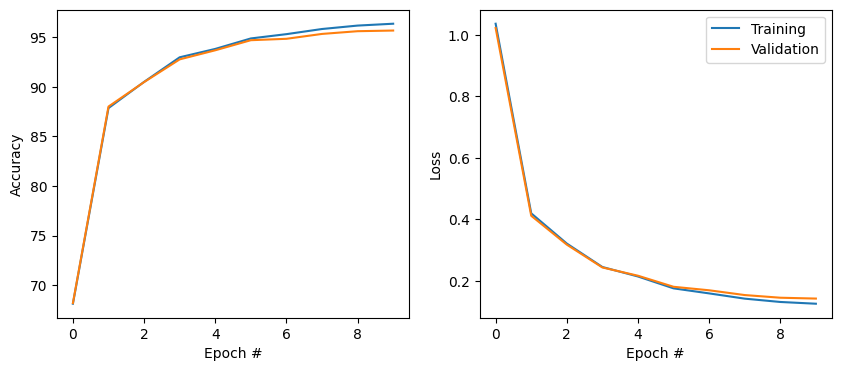

Test loss: 0.1399, test accuracy: 95.73%
Epoch 0: training loss: 1.9551546954094094, accuracy: 35.53333333333333
Epoch 0: val. loss: 1.951943462093671, val. accuracy: 36.016666666666666
Epoch 1: training loss: 0.808097427195691, accuracy: 73.80624999999999
Epoch 1: val. loss: 0.8047493696212769, val. accuracy: 73.51666666666667
Epoch 2: training loss: 0.489499642810923, accuracy: 86.27291666666666
Epoch 2: val. loss: 0.48350825781623524, val. accuracy: 86.31666666666666
Epoch 3: training loss: 0.3887232741776933, accuracy: 89.01041666666667
Epoch 3: val. loss: 0.38323364531000453, val. accuracy: 88.96666666666667
Epoch 4: training loss: 0.33074162519992667, accuracy: 90.51458333333333
Epoch 4: val. loss: 0.3237566016614437, val. accuracy: 90.64166666666667
Epoch 5: training loss: 0.2933837264142138, accuracy: 91.6375
Epoch 5: val. loss: 0.28804333818455535, val. accuracy: 91.55
Epoch 6: training loss: 0.26272397456651037, accuracy: 92.47083333333333
Epoch 6: val. loss: 0.25887177822490

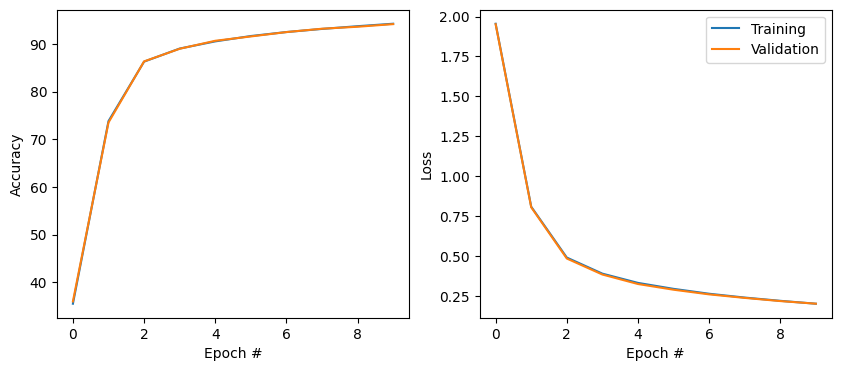

Test loss: 0.1997, test accuracy: 94.04%


In [32]:
epochs = 10
for batch_size in [32, 64, 128, 256, 512]:

  # The dataloader makes our dataset iterable
  train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
  val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
  test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

  nonlinear_model = NonlinearClassifier()
  optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

  loss_acc = train_epochs(epochs, train_dataloader, val_dataloader, nonlinear_model,
                 optimizer, scheduler=None)

  print(f"batch size: {batch_size}")
  plot_learning_curve(loss_acc)

  # model performance on test data
  model = loss_acc['model']
  acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
  print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

## Experiment on learning rate
Learning rate has a significant contribution in model performance. For our model, learning rate = 0.1 has the highest accuracy. Too small learning rates may converge to a local minimum or the convergence may be too slow. Too high learning rates may diverge and miss the minima.

Epoch 0: training loss: 2.3053089278809566, accuracy: 9.735416666666667
Epoch 0: val. loss: 2.3051870072141605, val. accuracy: 9.816666666666666
Epoch 1: training loss: 2.3045140365336803, accuracy: 9.735416666666667
Epoch 1: val. loss: 2.304386336752709, val. accuracy: 9.816666666666666
Epoch 2: training loss: 2.303730073127341, accuracy: 9.735416666666667
Epoch 2: val. loss: 2.303596562527596, val. accuracy: 9.816666666666666
Epoch 3: training loss: 2.3029541880526443, accuracy: 9.735416666666667
Epoch 3: val. loss: 2.3028165127368685, val. accuracy: 9.816666666666666
Epoch 4: training loss: 2.3021803003676395, accuracy: 9.735416666666667
Epoch 4: val. loss: 2.3020377057663937, val. accuracy: 9.816666666666666
Epoch 5: training loss: 2.3013980946642287, accuracy: 9.735416666666667
Epoch 5: val. loss: 2.301248935942954, val. accuracy: 9.816666666666666
Epoch 6: training loss: 2.300609659641347, accuracy: 9.735416666666667
Epoch 6: val. loss: 2.3004518519056605, val. accuracy: 9.816666

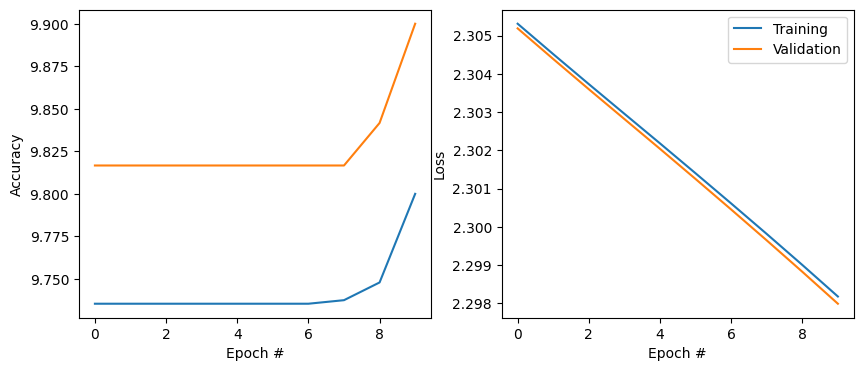

Test loss: 2.2981, test accuracy: 9.79%
Epoch 0: training loss: 2.2980160294695104, accuracy: 9.972916666666666
Epoch 0: val. loss: 2.298054421201665, val. accuracy: 9.966666666666667
Epoch 1: training loss: 2.284950319756853, accuracy: 19.085416666666667
Epoch 1: val. loss: 2.284870005668478, val. accuracy: 18.925
Epoch 2: training loss: 2.2607583948906433, accuracy: 20.785416666666666
Epoch 2: val. loss: 2.2605193828014616, val. accuracy: 20.666666666666668
Epoch 3: training loss: 2.2058021895428923, accuracy: 24.59375
Epoch 3: val. loss: 2.2054508391847003, val. accuracy: 24.59166666666667
Epoch 4: training loss: 2.0814816685433084, accuracy: 34.4875
Epoch 4: val. loss: 2.0806463576377707, val. accuracy: 34.641666666666666
Epoch 5: training loss: 1.8689858292011505, accuracy: 40.00833333333333
Epoch 5: val. loss: 1.8668045008436163, val. accuracy: 39.641666666666666
Epoch 6: training loss: 1.6207606938291104, accuracy: 51.81458333333333
Epoch 6: val. loss: 1.6165114260734397, val. a

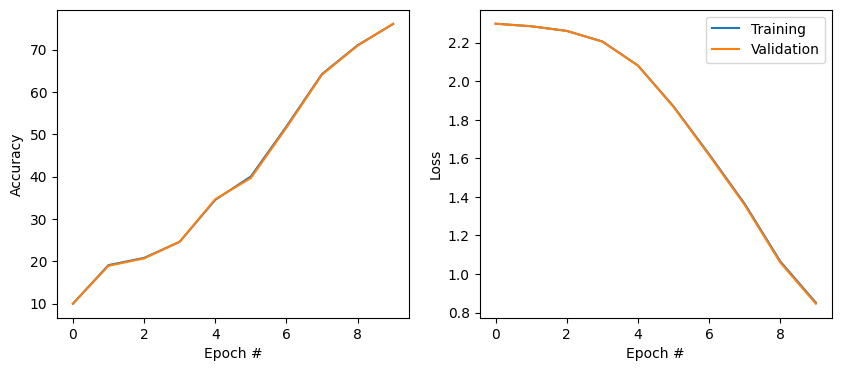

Test loss: 0.8303, test accuracy: 76.74%
Epoch 0: training loss: 0.7630110826898129, accuracy: 76.63958333333333
Epoch 0: val. loss: 0.7497977132492877, val. accuracy: 76.44999999999999
Epoch 1: training loss: 0.43651052072961277, accuracy: 86.97083333333333
Epoch 1: val. loss: 0.4324087487890365, val. accuracy: 86.89166666666667
Epoch 2: training loss: 0.31911245939579413, accuracy: 90.69166666666668
Epoch 2: val. loss: 0.31591878102180804, val. accuracy: 90.56666666666666
Epoch 3: training loss: 0.27638791541152813, accuracy: 91.90833333333333
Epoch 3: val. loss: 0.27488328928643085, val. accuracy: 91.625
Epoch 4: training loss: 0.23200314539544126, accuracy: 93.19791666666667
Epoch 4: val. loss: 0.23423658723526813, val. accuracy: 92.86666666666666
Epoch 5: training loss: 0.21531657078006167, accuracy: 93.67916666666667
Epoch 5: val. loss: 0.2196915422348266, val. accuracy: 93.16666666666666
Epoch 6: training loss: 0.18231942223266084, accuracy: 94.6
Epoch 6: val. loss: 0.1875044621

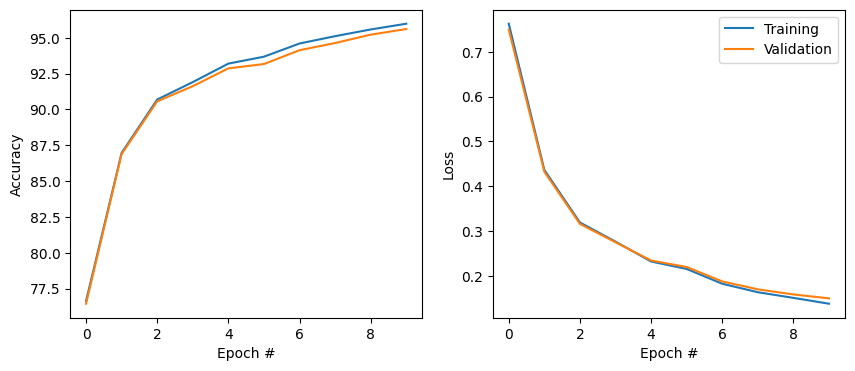

Test loss: 0.1505, test accuracy: 95.27%
Epoch 0: training loss: 0.5910199546116464, accuracy: 79.54583333333333
Epoch 0: val. loss: 0.5831266001183936, val. accuracy: 79.55
Epoch 1: training loss: 0.33217607391007403, accuracy: 90.50208333333333
Epoch 1: val. loss: 0.33702810013547857, val. accuracy: 90.16666666666666
Epoch 2: training loss: 0.3735492916658838, accuracy: 87.50833333333333
Epoch 2: val. loss: 0.3865898695397884, val. accuracy: 87.26666666666667
Epoch 3: training loss: 0.3016502303170397, accuracy: 90.85625
Epoch 3: val. loss: 0.31473533270206855, val. accuracy: 90.64166666666667
Epoch 4: training loss: 0.24941700316490012, accuracy: 93.31458333333333
Epoch 4: val. loss: 0.2597794878356, val. accuracy: 92.93333333333334
Epoch 5: training loss: 0.24504735138505063, accuracy: 92.76666666666667
Epoch 5: val. loss: 0.2629071902087394, val. accuracy: 92.18333333333332
Epoch 6: training loss: 0.1781399823487439, accuracy: 95.01666666666667
Epoch 6: val. loss: 0.19669800933371

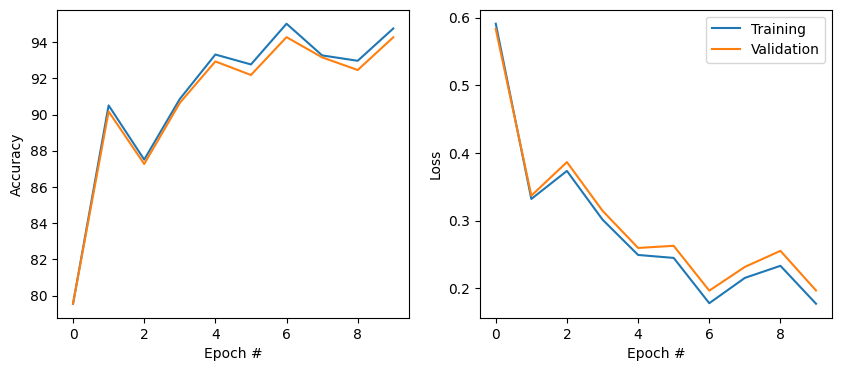

Test loss: 0.2216, test accuracy: 93.78%


In [34]:
epochs = 10
batch_size = 256
for learning_rate in [0.001, 0.01, 0.1, 1]:

  # The dataloader makes our dataset iterable
  train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
  val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
  test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

  nonlinear_model = NonlinearClassifier()
  optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=learning_rate)

  loss_acc = train_epochs(epochs, train_dataloader, val_dataloader, nonlinear_model,
                 optimizer, scheduler=None)

  print(f"learning rate: {learning_rate}")
  plot_learning_curve(loss_acc)

  # model performance on test data
  model = loss_acc['model']
  acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
  print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))


## Experiment on activation functions
ReLU has the best performance for the current model among ReLU, sigmoid, and Tanh.

### Sigmoid
For this model, changing activation function to sigmoid results in slower convergence and worse performance with 10 epochs. The performance might improve by increasing number of epochs.

Epoch 0: training loss: 2.302671230853872, accuracy: 11.2375
Epoch 0: val. loss: 2.3028051396633717, val. accuracy: 11.233333333333333
Epoch 1: training loss: 2.3024507405910084, accuracy: 11.2375
Epoch 1: val. loss: 2.3025816450727747, val. accuracy: 11.233333333333333
Epoch 2: training loss: 2.3022150257800487, accuracy: 11.2375
Epoch 2: val. loss: 2.3023439417494105, val. accuracy: 11.233333333333333
Epoch 3: training loss: 2.30195485657834, accuracy: 11.2375
Epoch 3: val. loss: 2.3020811334569404, val. accuracy: 11.233333333333333
Epoch 4: training loss: 2.3016495552468808, accuracy: 11.2375
Epoch 4: val. loss: 2.301773913363193, val. accuracy: 11.233333333333333
Epoch 5: training loss: 2.301283722228192, accuracy: 11.2375
Epoch 5: val. loss: 2.3014066574421337, val. accuracy: 11.233333333333333
Epoch 6: training loss: 2.3008297060398344, accuracy: 11.2375
Epoch 6: val. loss: 2.3009508924281343, val. accuracy: 11.233333333333333
Epoch 7: training loss: 2.3002394044652896, accuracy:

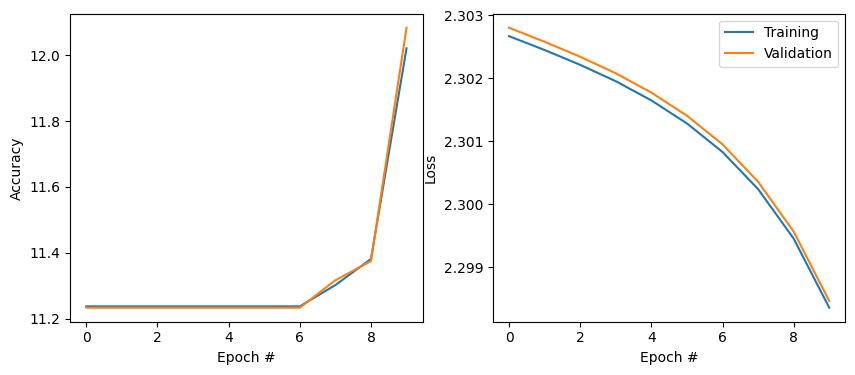

Test loss: 2.2980, test accuracy: 12.38%


In [35]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Sigmoid(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

batch_size = 256
learning_rate = 0.1
# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

nonlinear_model = NonlinearClassifier()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=learning_rate)

loss_acc = train_epochs(epochs, train_dataloader, val_dataloader, nonlinear_model,
                optimizer, scheduler=None)

print(f"learning rate: {learning_rate}")
plot_learning_curve(loss_acc)

# model performance on test data
model = loss_acc['model']
acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))


### Tanh

Epoch 0: training loss: 0.5601365677219756, accuracy: 85.36041666666667
Epoch 0: val. loss: 0.5526737158602857, val. accuracy: 85.45833333333334
Epoch 1: training loss: 0.3722145809455121, accuracy: 89.6625
Epoch 1: val. loss: 0.3629050914277422, val. accuracy: 89.60000000000001
Epoch 2: training loss: 0.3243375221624019, accuracy: 90.82708333333333
Epoch 2: val. loss: 0.31509364951164165, val. accuracy: 90.73333333333333
Epoch 3: training loss: 0.29484835425589945, accuracy: 91.53750000000001
Epoch 3: val. loss: 0.2882421596887264, val. accuracy: 91.43333333333334
Epoch 4: training loss: 0.2702802139869396, accuracy: 92.10833333333333
Epoch 4: val. loss: 0.2652170423497545, val. accuracy: 92.10833333333333
Epoch 5: training loss: 0.24762929508343656, accuracy: 92.76458333333333
Epoch 5: val. loss: 0.2455451006584979, val. accuracy: 92.55833333333334
Epoch 6: training loss: 0.23282168734263867, accuracy: 93.12708333333333
Epoch 6: val. loss: 0.23158582062163252, val. accuracy: 93.10000

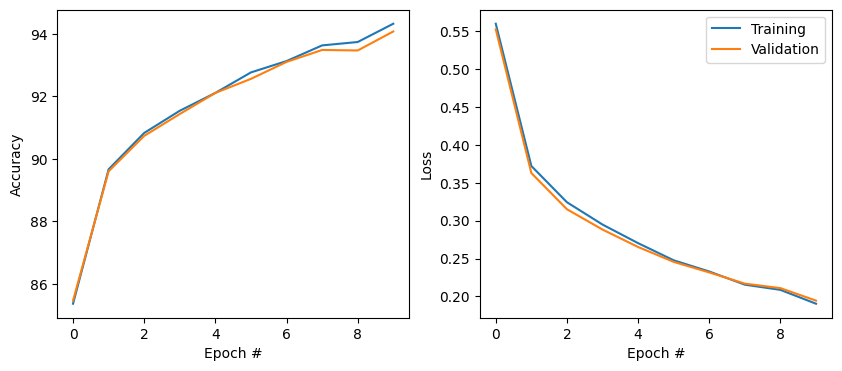

Test loss: 0.1965, test accuracy: 93.99%


In [36]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

batch_size = 256
learning_rate = 0.1
# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

nonlinear_model = NonlinearClassifier()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=learning_rate)

loss_acc = train_epochs(epochs, train_dataloader, val_dataloader, nonlinear_model,
                optimizer, scheduler=None)

print(f"learning rate: {learning_rate}")
plot_learning_curve(loss_acc)

# model performance on test data
model = loss_acc['model']
acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Bonus question: A learning rate scheduler is an essential deep learning technique used to dynamically adjust the learning rate during training. This strategy can significantly impact the convergence speed and overall performance of a neural network.

Epoch 1/50, Learning Rate: 0.1
Epoch 0: training loss: 0.9139399157559618, accuracy: 67.92708333333334
Epoch 0: val. loss: 0.907617893624813, val. accuracy: 68.125
Epoch 2/50, Learning Rate: 0.1
Epoch 1: training loss: 0.4059496468051951, accuracy: 88.67291666666667
Epoch 1: val. loss: 0.40065323038304107, val. accuracy: 88.46666666666667
Epoch 3/50, Learning Rate: 0.1
Epoch 2: training loss: 0.304136824496883, accuracy: 91.41875
Epoch 2: val. loss: 0.2975541039350185, val. accuracy: 91.33333333333333
Epoch 4/50, Learning Rate: 0.1
Epoch 3: training loss: 0.2563835794621326, accuracy: 92.70208333333333
Epoch 3: val. loss: 0.25346044466850604, val. accuracy: 92.50833333333334
Epoch 5/50, Learning Rate: 0.06999999999999999
Epoch 4: training loss: 0.2251058095630179, accuracy: 93.45833333333333
Epoch 4: val. loss: 0.2258435221428567, val. accuracy: 93.06666666666666
Epoch 6/50, Learning Rate: 0.06999999999999999
Epoch 5: training loss: 0.18889700756111044, accuracy: 94.51875
Epoch 5: val.

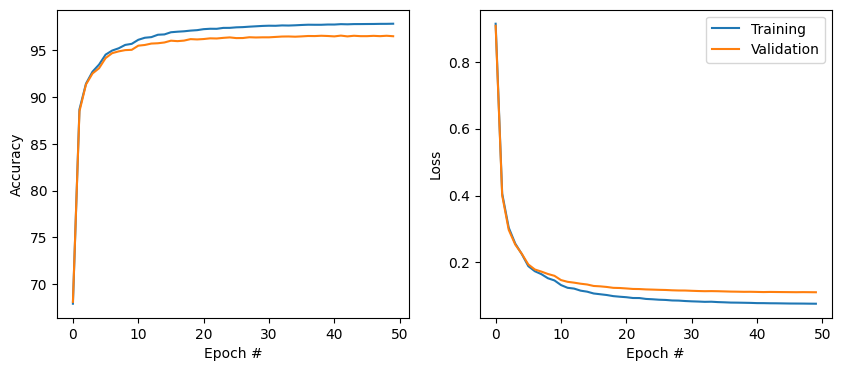

Test loss: 0.1039, test accuracy: 96.84%


In [37]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x


batch_size = 256
learning_rate = 0.1
epochs = 50
# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

nonlinear_model = NonlinearClassifier()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)
# learning rate decay by a factor of 0.7 after 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

loss_acc = train_epochs(epochs, train_dataloader, val_dataloader, nonlinear_model,
                optimizer, scheduler=scheduler)

print(f"learning rate: {learning_rate}")
plot_learning_curve(loss_acc)

# model performance on test data
model = loss_acc['model']
acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))
